# Manhattan Taxi Rebalancing Time Analysis

This notebook analyzes taxi trip data to calculate rebalancing times between Manhattan zip codes during afternoon and evening hours (12 PM - 11 PM).

In [24]:
# Import all required libraries
import pandas as pd
import geopandas as gpd
import glob
import itertools
import matplotlib.pyplot as plt
import numpy as np

## 1. Configuration and Setup

In [25]:
# Configuration
MANHATTAN_ZIP_CODES = ['10002', '10003', '10005', '10006', '10007', '10009', 
                       '10010', '10011', '10012', '10013', '10014', '10038']
TIMEFRAMES = list(range(12, 24))  # 12 PM to 11 PM
MAX_REBALANCING_TIME = 100  # minutes

# Helper function for spatial join with duplicate handling
def assign_zip_codes(points, zones):
    """Assign zip codes to points via spatial join, handling duplicates."""
    gdf = gpd.GeoDataFrame(
        pd.Series(range(len(points)), name='original_index'),
        geometry=points,
        crs="EPSG:4326"
    )
    gdf = gpd.sjoin(gdf, zones[['geometry', 'postalCode']], how="left", predicate="intersects")
    gdf = gdf.drop_duplicates(subset=['original_index'], keep='first').sort_values('original_index')
    return gdf['postalCode'].values

## 2. Load and Process Trip Data

In [26]:
# Load NYC zip code geometries (used throughout notebook)
nyc_zones = gpd.read_file("nyc-zip-code-tabulation-areas-polygons.geojson").to_crs(epsg=4326)
manhattan_zones = nyc_zones[nyc_zones['postalCode'].isin(MANHATTAN_ZIP_CODES)]

# Find all trip data files
csv_files = glob.glob("Trip Data/trip_data_3.csv")
print(f"Found {len(csv_files)} files to process\n" + "=" * 60)

dfs = []
for idx, file in enumerate(csv_files, 1):
    print(f"\n[{idx}/{len(csv_files)}] Processing: {file}")
    
    # Load CSV with optimized dtypes
    df = pd.read_csv(
        file,
        dtype={
            'pickup_longitude': 'float32', 'pickup_latitude': 'float32',
            'dropoff_longitude': 'float32', 'dropoff_latitude': 'float32',
            'trip_time_in_secs': 'float32',
            ' pickup_longitude': 'float32', ' pickup_latitude': 'float32',
            ' dropoff_longitude': 'float32', ' dropoff_latitude': 'float32',
            ' trip_time_in_secs': 'float32'
        },
        low_memory=False
    )
    df.columns = df.columns.str.strip()
    print(f"  Loaded {len(df):,} rows")
    
    # Keep only required columns
    needed_cols = ['pickup_datetime', 'pickup_longitude', 'pickup_latitude', 
                   'dropoff_longitude', 'dropoff_latitude', 'trip_time_in_secs']
    df = df[[col for col in needed_cols if col in df.columns]]
    
    if 'pickup_datetime' not in df.columns:
        print(f"  ⚠️  Skipped (no pickup_datetime column)")
        continue
    
    # Filter by time and clean data
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
    df['time_stamp'] = df['pickup_datetime'].dt.hour 
    df = df[df['time_stamp'].isin(TIMEFRAMES)]
    print(f"  Filtered to {len(df):,} rows for hours {min(TIMEFRAMES)}-{max(TIMEFRAMES)}")
    
    df = df.dropna(subset=['pickup_longitude', 'pickup_latitude', 
                           'dropoff_longitude', 'dropoff_latitude'])
    print(f"  After dropping nulls: {len(df):,} rows")
    
    # Convert trip time to minutes
    df['reb_time'] = df['trip_time_in_secs'] / 60
    
    # Assign zip codes using spatial join
    df = df.reset_index(drop=True)
    pickup_points = gpd.points_from_xy(df['pickup_longitude'], df['pickup_latitude'])
    dropoff_points = gpd.points_from_xy(df['dropoff_longitude'], df['dropoff_latitude'])
    
    df['pickup_zone'] = assign_zip_codes(pickup_points, manhattan_zones)
    df['dropoff_zone'] = assign_zip_codes(dropoff_points, manhattan_zones)
    
    # Filter for Manhattan-to-Manhattan trips within time limit
    df = df[
        df['pickup_zone'].isin(MANHATTAN_ZIP_CODES) &
        df['dropoff_zone'].isin(MANHATTAN_ZIP_CODES) &
        (df['reb_time'] <= MAX_REBALANCING_TIME)
    ].copy()
    print(f"  Manhattan trips (≤{MAX_REBALANCING_TIME} min): {len(df):,} rows")
    
    dfs.append(df[['time_stamp', 'pickup_zone', 'dropoff_zone', 'reb_time']])
    print(f"  ✓ File processed successfully")

# Merge all data and calculate averages
print("\n" + "=" * 60)
merged_df = pd.concat(dfs, ignore_index=True)
print(f"✓ Total trips collected: {len(merged_df):,}")

average_reb_time = merged_df.groupby(['time_stamp', 'pickup_zone', 'dropoff_zone'])['reb_time'].mean().reset_index()
print(f"✓ Calculated {len(average_reb_time):,} unique hour/zone combinations")

# Save average rebalancing times
average_reb_time.to_csv("average_reb_times_manhattan.csv", index=False)
print("💾 Saved average rebalancing times to 'average_reb_times_manhattan.csv'")

print("\n" + "=" * 60 + "\nCOMPLETE!\n" + "=" * 60)

del merged_df
average_reb_time.head()

Found 1 files to process

[1/1] Processing: Trip Data/trip_data_3.csv
  Loaded 15,749,228 rows
  Loaded 15,749,228 rows
  Filtered to 9,991,022 rows for hours 12-23
  Filtered to 9,991,022 rows for hours 12-23
  After dropping nulls: 9,990,775 rows
  After dropping nulls: 9,990,775 rows
  Manhattan trips (≤100 min): 1,359,593 rows
  ✓ File processed successfully

✓ Total trips collected: 1,359,593
✓ Calculated 1,728 unique hour/zone combinations
💾 Saved average rebalancing times to 'average_reb_times_manhattan.csv'

COMPLETE!
  Manhattan trips (≤100 min): 1,359,593 rows
  ✓ File processed successfully

✓ Total trips collected: 1,359,593
✓ Calculated 1,728 unique hour/zone combinations
💾 Saved average rebalancing times to 'average_reb_times_manhattan.csv'

COMPLETE!


,time_stamp,pickup_zone,dropoff_zone,reb_time
0,12,10002,10002,6.378877
1,12,10002,10003,7.341270
2,12,10002,10005,10.005673
3,12,10002,10006,14.370417
4,12,10002,10007,12.263954


## 3. Complete Rebalancing Time Matrix

Fill in missing time slots and ensure complete coverage for all zip code pairs.

In [27]:
# Create complete matrix of all possible combinations
all_pairs = pd.DataFrame(
    list(itertools.product(TIMEFRAMES, MANHATTAN_ZIP_CODES, MANHATTAN_ZIP_CODES)), 
    columns=['time_stamp', 'pickup_zone', 'dropoff_zone']
)

reb_time = all_pairs.merge(average_reb_time, on=['time_stamp', 'pickup_zone', 'dropoff_zone'], how='left')

# Fill missing values
missing_count = reb_time['reb_time'].isna().sum()
if missing_count > 0:
    print(f"Initial missing values: {missing_count:,}")
    
    # Step 1: Fill within each pickup-dropoff pair across time
    print("Step 1: Forward/backward fill within pickup-dropoff pairs...")
    reb_time['reb_time'] = reb_time.groupby(['pickup_zone', 'dropoff_zone'])['reb_time'].transform(
        lambda x: x.ffill().bfill()
    )
    remaining = reb_time['reb_time'].isna().sum()
    print(f"  Remaining: {remaining:,}")
    
    # Step 2: Fill with time_stamp average
    if remaining > 0:
        print("Step 2: Imputing with time_stamp averages...")
        time_avg = reb_time.groupby('time_stamp')['reb_time'].transform('mean')
        reb_time['reb_time'] = reb_time['reb_time'].fillna(time_avg)
        print(f"  Final missing: {reb_time['reb_time'].isna().sum():,}")

# Set same-zone rebalancing times to 0
same_zone_mask = reb_time['pickup_zone'] == reb_time['dropoff_zone']
reb_time.loc[same_zone_mask, 'reb_time'] = 0
print(f"\nSet {same_zone_mask.sum():,} same-zone pairs to 0 minutes")


Set 144 same-zone pairs to 0 minutes


## 4. Statistical Analysis

Analyze rebalancing patterns for a specific hour (7 PM / Hour 19).

In [28]:
# Analyze Hour 19 (7 PM)
hour_19_data = reb_time[reb_time['time_stamp'] == 19].copy()
valid_count = (~hour_19_data['reb_time'].isna()).sum()

# Print statistics
print("=" * 70)
print("📊 HOUR 19 (7 PM) REBALANCING TIME ANALYSIS")
print("=" * 70)
print(f"\n📍 Coverage: {valid_count:,} / {len(hour_19_data):,} zip code pairs ({valid_count/len(hour_19_data)*100:.1f}%)")

if valid_count > 0:
    stats = hour_19_data['reb_time'].describe()
    print(f"\n📈 Rebalancing Time Statistics (minutes):")
    print(f"   Mean: {stats['mean']:.2f}  |  Median: {stats['50%']:.2f}  |  Std: {stats['std']:.2f}")
    print(f"   Min: {stats['min']:.2f}  |  Max: {stats['max']:.2f}")
    print(f"   25th %ile: {stats['25%']:.2f}  |  75th %ile: {stats['75%']:.2f}")
    
    # Compare same-zone vs different-zone
    same_zone = hour_19_data[hour_19_data['pickup_zone'] == hour_19_data['dropoff_zone']]
    diff_zone = hour_19_data[hour_19_data['pickup_zone'] != hour_19_data['dropoff_zone']]
    print(f"\n🚖 Trip Types:")
    print(f"   Same zip: {len(same_zone):,} trips (avg: {same_zone['reb_time'].mean():.2f} min)")
    print(f"   Different zip: {len(diff_zone):,} trips (avg: {diff_zone['reb_time'].mean():.2f} min)")

print("\n" + "=" * 70)

📊 HOUR 19 (7 PM) REBALANCING TIME ANALYSIS

📍 Coverage: 144 / 144 zip code pairs (100.0%)

📈 Rebalancing Time Statistics (minutes):
   Mean: 9.28  |  Median: 9.65  |  Std: 4.02
   Min: 0.00  |  Max: 16.15
   25th %ile: 7.02  |  75th %ile: 12.49

🚖 Trip Types:
   Same zip: 12 trips (avg: 0.00 min)
   Different zip: 132 trips (avg: 10.12 min)



C:\Users\emilk\AppData\Local\Temp\ipykernel_39184\3410528428.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(
C:\Users\emilk\AppData\Local\Temp\ipykernel_39184\3410528428.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


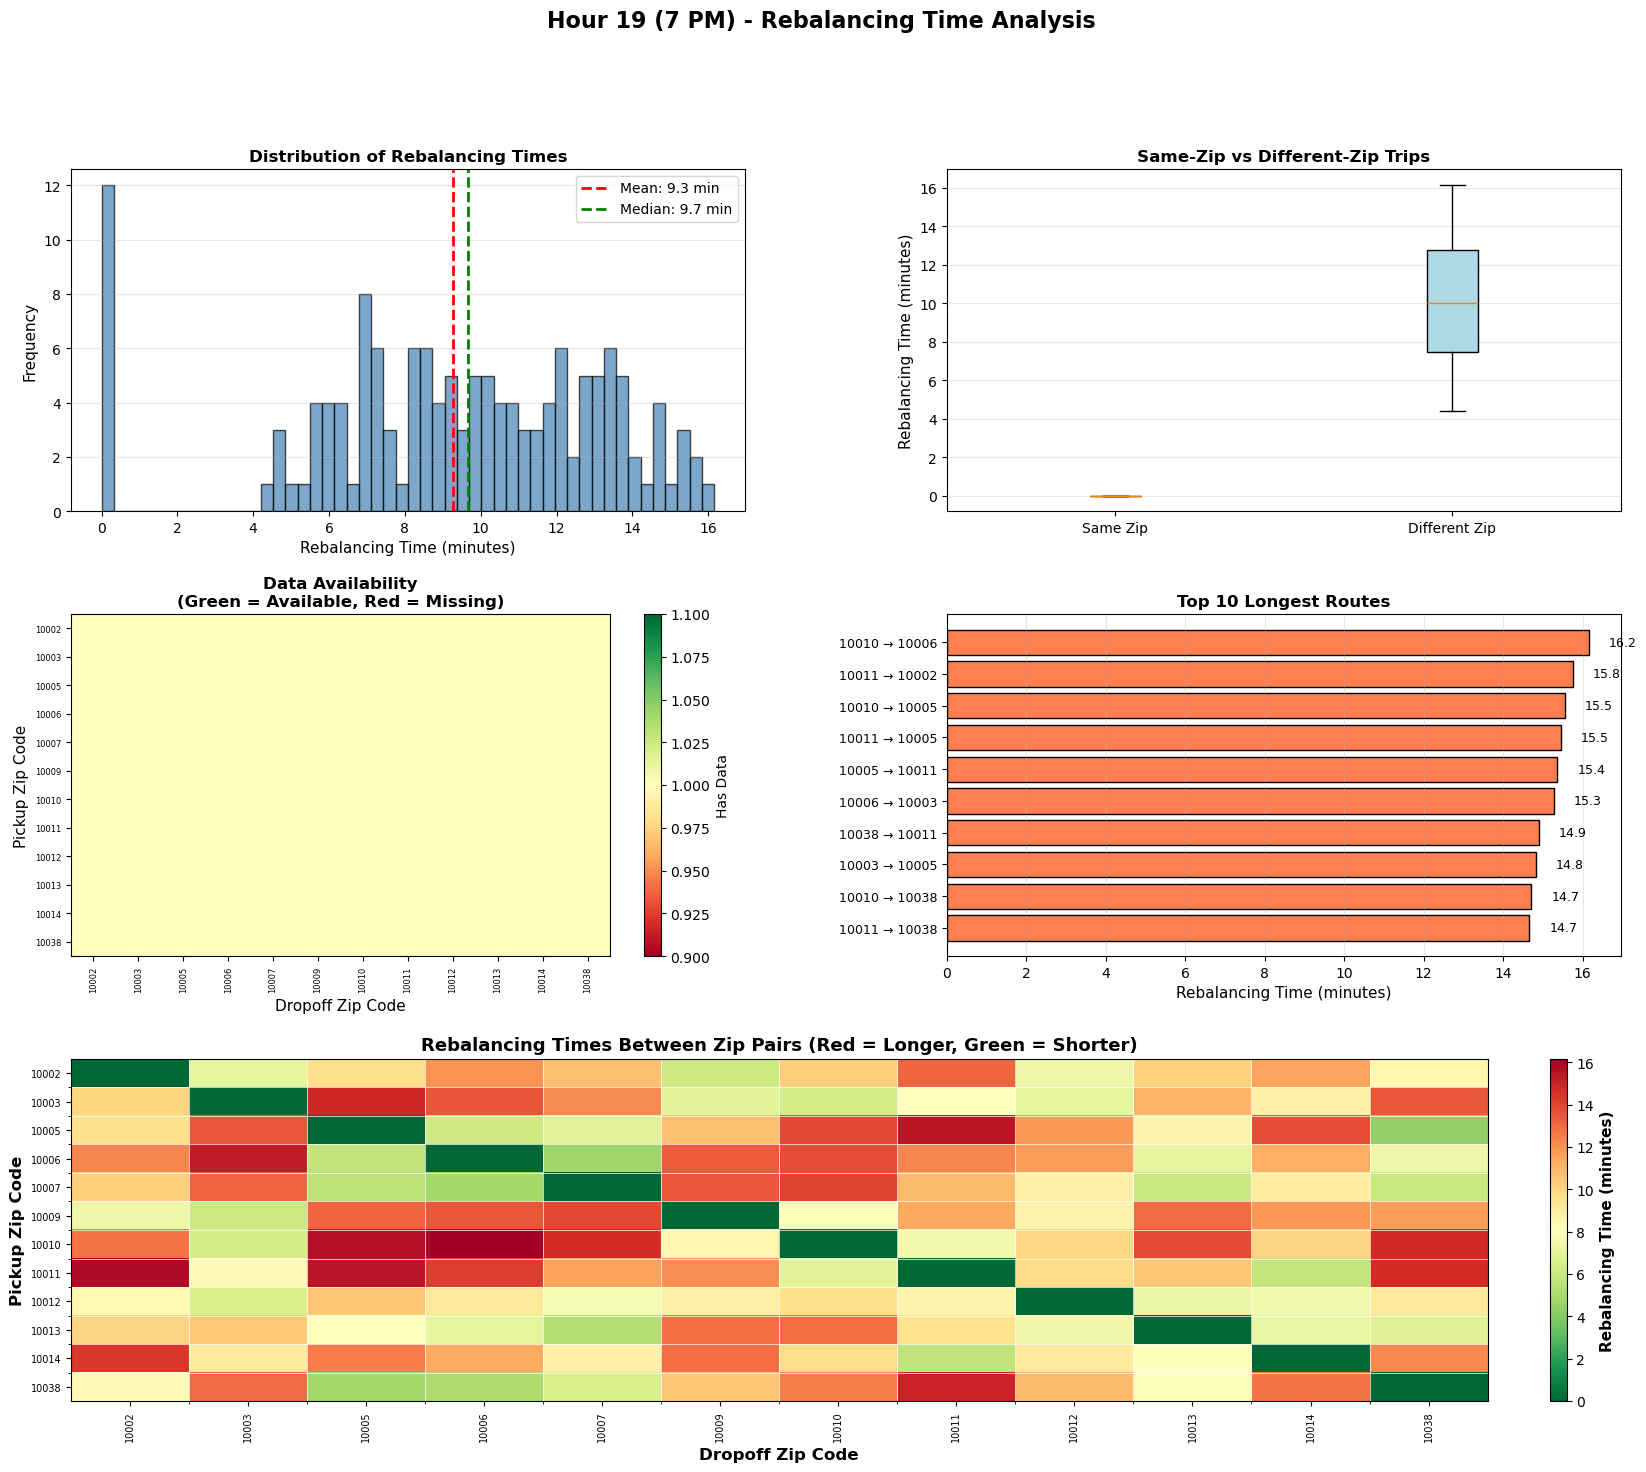

In [29]:
# Create comprehensive visualization dashboard
if valid_count > 0:
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    fig.suptitle('Hour 19 (7 PM) - Rebalancing Time Analysis', fontsize=16, fontweight='bold')
    
    # 1. Distribution histogram
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.hist(hour_19_data['reb_time'].dropna(), bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    ax1.axvline(hour_19_data['reb_time'].mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {hour_19_data["reb_time"].mean():.1f} min')
    ax1.axvline(hour_19_data['reb_time'].median(), color='green', linestyle='--', linewidth=2, 
                label=f'Median: {hour_19_data["reb_time"].median():.1f} min')
    ax1.set_xlabel('Rebalancing Time (minutes)', fontsize=11)
    ax1.set_ylabel('Frequency', fontsize=11)
    ax1.set_title('Distribution of Rebalancing Times', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # 2. Same vs Different zip comparison
    ax2 = fig.add_subplot(gs[0, 1])
    bp = ax2.boxplot(
        [same_zone['reb_time'].dropna(), diff_zone['reb_time'].dropna()],
        labels=['Same Zip', 'Different Zip'],
        patch_artist=True
    )
    for patch, color in zip(bp['boxes'], ['lightcoral', 'lightblue']):
        patch.set_facecolor(color)
    ax2.set_ylabel('Rebalancing Time (minutes)', fontsize=11)
    ax2.set_title('Same-Zip vs Different-Zip Trips', fontsize=12, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    
    # 3. Data availability matrix
    ax3 = fig.add_subplot(gs[1, 0])
    pivot = hour_19_data.pivot_table(values='reb_time', index='pickup_zone', columns='dropoff_zone', aggfunc='first')
    im3 = ax3.imshow(~pivot.isna(), cmap='RdYlGn', aspect='auto', interpolation='nearest')
    ax3.set_xlabel('Dropoff Zip Code', fontsize=11)
    ax3.set_ylabel('Pickup Zip Code', fontsize=11)
    ax3.set_title('Data Availability\n(Green = Available, Red = Missing)', fontsize=12, fontweight='bold')
    ax3.set_xticks(range(len(MANHATTAN_ZIP_CODES)))
    ax3.set_yticks(range(len(MANHATTAN_ZIP_CODES)))
    ax3.set_xticklabels(MANHATTAN_ZIP_CODES, fontsize=6, rotation=90)
    ax3.set_yticklabels(MANHATTAN_ZIP_CODES, fontsize=6)
    plt.colorbar(im3, ax=ax3, label='Has Data')
    
    # 4. Top 10 longest routes
    ax4 = fig.add_subplot(gs[1, 1])
    top_10 = hour_19_data.nlargest(10, 'reb_time')
    labels = [f"{row['pickup_zone']} → {row['dropoff_zone']}" for _, row in top_10.iterrows()]
    ax4.barh(range(10), top_10['reb_time'].values, color='coral', edgecolor='black')
    ax4.set_yticks(range(10))
    ax4.set_yticklabels(labels, fontsize=9)
    ax4.set_xlabel('Rebalancing Time (minutes)', fontsize=11)
    ax4.set_title('Top 10 Longest Routes', fontsize=12, fontweight='bold')
    ax4.grid(axis='x', alpha=0.3)
    ax4.invert_yaxis()
    for i, v in enumerate(top_10['reb_time'].values):
        ax4.text(v + 0.5, i, f'{v:.1f}', va='center', fontsize=9)
    
    # 5. Full heatmap
    ax5 = fig.add_subplot(gs[2, :])
    heatmap = hour_19_data.pivot_table(values='reb_time', index='pickup_zone', columns='dropoff_zone', aggfunc='first')
    im5 = ax5.imshow(heatmap, cmap='RdYlGn_r', aspect='auto', interpolation='nearest')
    ax5.set_xlabel('Dropoff Zip Code', fontsize=12, fontweight='bold')
    ax5.set_ylabel('Pickup Zip Code', fontsize=12, fontweight='bold')
    ax5.set_title('Rebalancing Times Between Zip Pairs (Red = Longer, Green = Shorter)', 
                  fontsize=13, fontweight='bold')
    ax5.set_xticks(range(len(MANHATTAN_ZIP_CODES)))
    ax5.set_yticks(range(len(MANHATTAN_ZIP_CODES)))
    ax5.set_xticklabels(MANHATTAN_ZIP_CODES, fontsize=7, rotation=90)
    ax5.set_yticklabels(MANHATTAN_ZIP_CODES, fontsize=7)
    cbar5 = plt.colorbar(im5, ax=ax5, fraction=0.046, pad=0.04)
    cbar5.set_label('Rebalancing Time (minutes)', fontsize=11, fontweight='bold')
    ax5.set_xticks([x - 0.5 for x in range(1, len(MANHATTAN_ZIP_CODES))], minor=True)
    ax5.set_yticks([y - 0.5 for y in range(1, len(MANHATTAN_ZIP_CODES))], minor=True)
    ax5.grid(which='minor', color='white', linestyle='-', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No valid data for visualization")

## 5. Geographic Visualizations

Choropleth map and flow map showing spatial patterns of rebalancing times.

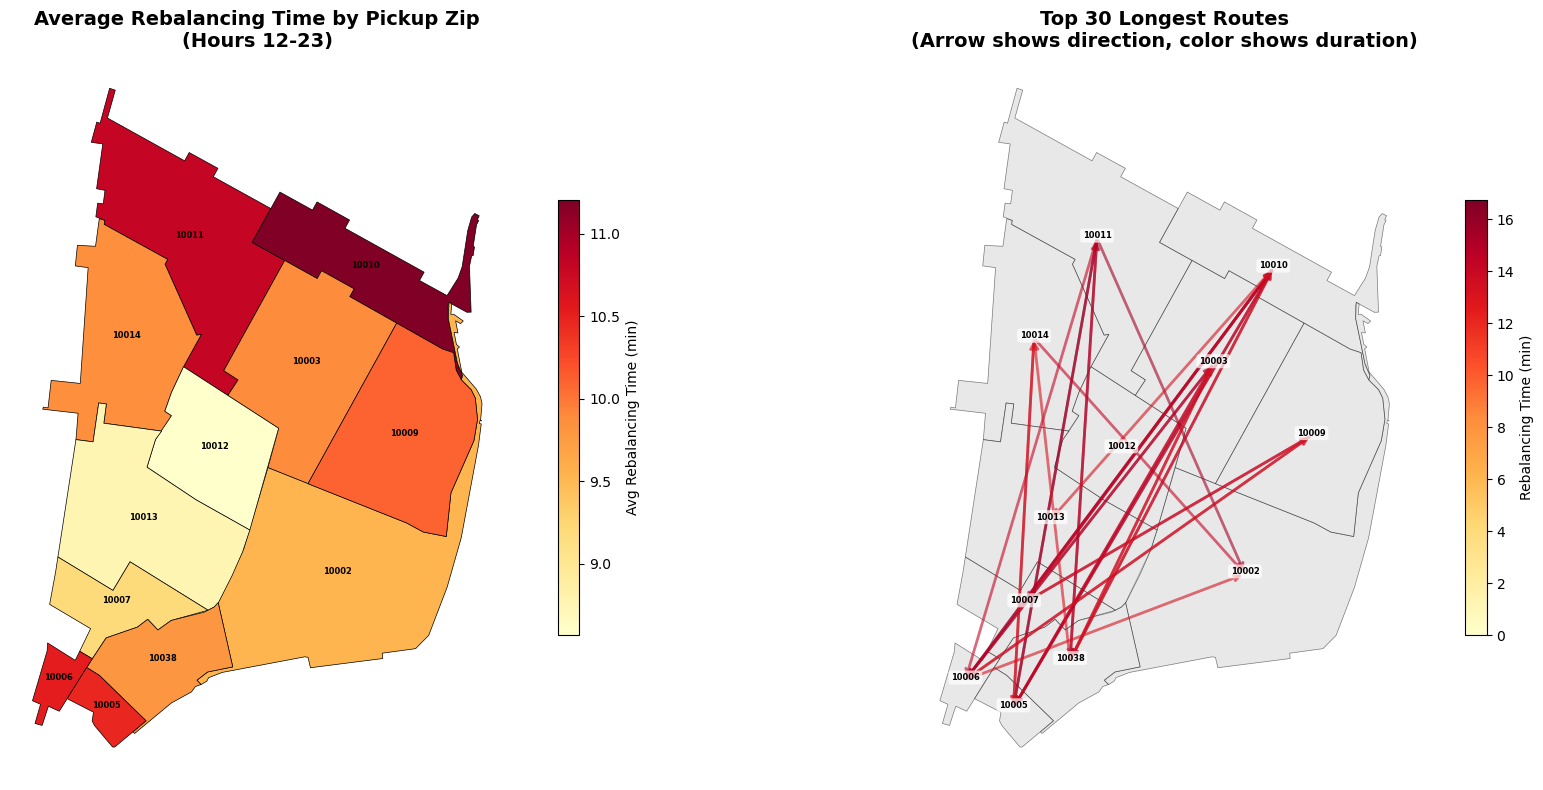

📊 Visualization saved as 'manhattan_rebalancing_visualization.png'


In [30]:
# Prepare geographic data
manhattan_zones_viz = nyc_zones[nyc_zones['postalCode'].isin(MANHATTAN_ZIP_CODES)]
avg_by_pickup = average_reb_time.groupby('pickup_zone')['reb_time'].mean().reset_index()
avg_by_pickup.columns = ['pickup_zone', 'avg_reb_time']
viz_data = manhattan_zones_viz.merge(avg_by_pickup, left_on='postalCode', right_on='pickup_zone', how='left')

# Create side-by-side visualizations
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# LEFT: Choropleth map of average rebalancing times
viz_data.plot(
    column='avg_reb_time',
    cmap='YlOrRd',
    legend=True,
    ax=axes[0],
    edgecolor='black',
    linewidth=0.5,
    legend_kwds={'label': 'Avg Rebalancing Time (min)', 'shrink': 0.6}
)
axes[0].set_title(f'Average Rebalancing Time by Pickup Zip\n(Hours {min(TIMEFRAMES)}-{max(TIMEFRAMES)})', 
                  fontsize=14, fontweight='bold')
axes[0].axis('off')

# Add zip code labels
for _, row in viz_data.iterrows():
    centroid = row.geometry.centroid
    axes[0].annotate(row['postalCode'], xy=(centroid.x, centroid.y), ha='center', 
                     fontsize=6, color='black', weight='bold')

# RIGHT: Flow map of top 30 longest routes
top_flows = average_reb_time[average_reb_time['pickup_zone'] != average_reb_time['dropoff_zone']].copy()
top_flows = top_flows.groupby(['pickup_zone', 'dropoff_zone'])['reb_time'].mean().reset_index()
top_flows = top_flows.nlargest(30, 'reb_time')

manhattan_zones_viz.plot(ax=axes[1], facecolor='lightgray', edgecolor='black', linewidth=0.5, alpha=0.5)
zone_centroids = {row['postalCode']: row.geometry.centroid for _, row in manhattan_zones_viz.iterrows()}

# Draw flow arrows
max_time = top_flows['reb_time'].max()
for _, flow in top_flows.iterrows():
    if flow['pickup_zone'] in zone_centroids and flow['dropoff_zone'] in zone_centroids:
        start = zone_centroids[flow['pickup_zone']]
        end = zone_centroids[flow['dropoff_zone']]
        color = plt.cm.YlOrRd(flow['reb_time'] / max_time)
        axes[1].annotate('', xy=(end.x, end.y), xytext=(start.x, start.y),
                        arrowprops=dict(arrowstyle='->', color=color, lw=2, alpha=0.6))

# Add zip labels
for code, centroid in zone_centroids.items():
    axes[1].annotate(code, xy=(centroid.x, centroid.y), ha='center', fontsize=6,
                     color='black', weight='bold',
                     bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='none', alpha=0.7))

axes[1].set_title('Top 30 Longest Routes\n(Arrow shows direction, color shows duration)', 
                  fontsize=14, fontweight='bold')
axes[1].axis('off')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=0, vmax=max_time))
sm._A = []
cbar = plt.colorbar(sm, ax=axes[1], shrink=0.6)
cbar.set_label('Rebalancing Time (min)', fontsize=10)

plt.tight_layout()
plt.savefig('manhattan_rebalancing_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Visualization saved as 'manhattan_rebalancing_visualization.png'")

## 6. Export Results

Save the complete rebalancing time matrix for further analysis.

In [31]:
# Export complete rebalancing time matrix
output_file = "south_manhattan_reb_times.csv"
reb_time.to_csv(output_file, index=False)

print(f"✓ Complete rebalancing time matrix saved to '{output_file}'")
print(f"  Total rows: {len(reb_time):,}")
print(f"  Columns: {', '.join(reb_time.columns)}")
print(f"  Time range: Hours {min(TIMEFRAMES)}-{max(TIMEFRAMES)}")
print(f"  Zip codes: {len(MANHATTAN_ZIP_CODES)}")

✓ Complete rebalancing time matrix saved to 'south_manhattan_reb_times.csv'
  Total rows: 1,728
  Columns: time_stamp, pickup_zone, dropoff_zone, reb_time
  Time range: Hours 12-23
  Zip codes: 12
